#### This notebook has all the steps from training to evaluation and postprocessing steps for only one model (VGG16) for extreme binary model and turned it to a 3-class classifier. It was based on the idea that small patches are only no damaged or high damaged tiles and the frequency of these tiles make the bigger image or WS low, medium or high damaged.


Salma 

In [ ]:
### This is for calculating 

import pandas as pd
df_scores = pd.read_excel(r'../../../data/raw_data/ROW_DATA_Sonja_add_MV_ECMO_and_ECMO_LPS.xlsx',sheet_name='Total Score',engine='openpyxl')
df_scores_Ct_MV_LP = df_scores[0:19]


this_data = df_scores['PDF/ EXCEL correspodent Data'].values
df_scores

### Training

#### I have added a extreme class classification, trained a 2 class tile level model and refined it to a 3 class classifier on slide level. The following training code was run on the gpu of my own laptop.

##libraries
my_imports.py

defined functions in 
Train/classifier.py

In [22]:
## functions and objects required for augnentation and trackcing results in each epoch (callbacks)
##################################################################
class MulticlassTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name='multiclass_true_positives', **kwargs):
        super(MulticlassTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)

##################################################################
class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, validation_data, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        
        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.asarray(self.model.predict(self.validation_data[0]))
        y_true = self.validation_data[1]             
        y_pred_class = np.argmax(y_pred, axis=1)

        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        plot_confusion_matrix(y_true, y_pred_class,labels=[0,1],true_labels=[0,1], ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

Defined in model/model_definition.py

In [ ]:
############################GPU ##################################
gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
#print(os.getenv('TF_GPU_ALLOCATOR'))
#################################################################
###### Model definition for classification#######################
def pretrained_model(img_shape, num_classes,layer_type):  ## load pretrained model first
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

    #Input format
    keras_input = Input(shape=(224,224,3), name = 'image_input')
    
    #Use the generated model 
    output_vgg16_conv = model_vgg16_conv(keras_input)
    
    for layer in model_vgg16_conv.layers:
        layer.trainable = False

    #Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(128, activation=layer_type, name='fc1')(x)
    x = Dense(128, activation=layer_type, name='fc2')(x)
    x = Dropout(0.5, name='dropout')(x)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    METRICS = [
      tf.keras.metrics.SparseCategoricalAccuracy(),
      MulticlassTruePositives()]
   
    #Create your own model 
    pretrained_model = Model(inputs=keras_input, outputs=x)
    pretrained_model.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam', metrics=METRICS)
    pretrained_model.summary()

    return pretrained_model


defined in Train/classifier.py

In [ ]:
###########################Training and validation data#####################
### Max and min of Median column 
max_score = max(df_scores['Median'])
min_score = min(df_scores['Median'])

low = (10-(min_score))/(max_score-min_score) ## This is still valid for training the model
mid = (25-(min_score))/(max_score-min_score)
## Thresholds are still valid for classifiying tiles to low, medium and high dmaaged classes
##############################################################################
########################## Training data #####################################
val_accuracy_dict  = {}
train_accuracy_dict = {}
val_loss_dict = {}
train_loss_dict = {}
validation_slide = ['1st_part','2nd_part','3rd_part']
for val_s in validation_slide:
    tf.keras.backend.clear_session()
    val_dir  = val_s
    train_DATA_PATH = val_dir+'_val_total_score_cropped/train/'
    validation_DATA_PATH = val_dir+'_val_total_score_cropped/validation/'
    input_shape = (224,224,3)

    train_images      = glob.glob(train_DATA_PATH+'*.tif')
    validation_images = glob.glob(validation_DATA_PATH+'*.tif')

    n_t= len(train_images)
    print('---------------train data size is {}-----------------'.format(n_t))
    with tf.device('/CPU:0'):
        train_samples = np.zeros((n_t, input_shape[0], input_shape[1], 3), dtype=np.float32)
        train_label   = np.zeros((n_t,), int)
        with open(LABEL_PATH+val_dir+'_val_total_score/train/train_newlabels.txt','r') as f:
            for ctr,line in zip(range(n_t),f):
                if io.imread(train_DATA_PATH+(line.split()[0])) is not None:
                    train_samples[ctr,:,:,:] = io.imread(train_DATA_PATH+(line.split()[0]))
                    la = float(line.split(' ')[1])
                    if la > mid:
                        train_label[ctr] = 1   ## Here I named classes 0, 2, 1. So 0 for low, 2 for medium, and 1 for high damaged class
                    elif la > low:
                        train_label[ctr] = 2
                    else:
                        train_label[ctr] = 0
                else:
                    print(line.split(' ')[0],'is None')
            
       
        new_train_label=train_label[(train_label!=2)]   ### This is where I removed second class which is medium damaged class from training data
        print('new_labels are:',new_train_label)
        new_train_samples=train_samples[(train_label!=2),:,:,:] ## removed from labels as well
        print('new_samples are:',new_train_samples.shape)        
     
        
        for i in range(len(new_train_label)):
            mod_img = new_train_samples[i,:, :, :].astype(np.float32)
            new_train_samples[i, :, :, :] = mod_img

     
        new_train_samples = np.clip(new_train_samples, 0, 255)
        print(val_dir,'trainnnnn  is ddoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooone!!')  
        
################################################################################
########################### Validation data #################################
        n_v= len(validation_images)
        print('hiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiivalidation data size is {}'.format(n_v))
        validation_samples = np.zeros((n_v, input_shape[0], input_shape[1], 3), dtype=np.float32)
        validation_label   = np.zeros((n_v,), int)

        with open(VAL_LABEL_PATH+val_dir+'_val_total_score/validation/'+'validation_newlabels.txt','r') as f:
            for ctr,line in zip(range(n_v),f):
                if cv2.imread(validation_DATA_PATH+(line.split()[0])) is not None:
                    validation_samples[ctr,:,:,:]=cv2.imread(validation_DATA_PATH+(line.split()[0]))
                    la = float(line.split()[1])
                    if la > mid:
                        validation_label[ctr] = 1  # here the same 0,2,1 
                    elif la > low:
                        validation_label[ctr] = 2
                    else:
                        validation_label[ctr] = 0
                else:
                    print(line.split(' ')[0],'is Noneeee')
        new_validation_label  = validation_label[(validation_label!=2)]
        new_validation_samples= validation_samples[(validation_label!=2),:,:,:]
        print('new_validation_label:',new_validation_label)   ### This is new validaion data and labels (only 0, and 1)  

        print(val_dir,'is ddoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooone!!')  
        for i in range(len(new_validation_label)):
            mod_img = new_validation_samples[i,:, :,:].astype(np.float32)
            new_validation_samples[i, :, :, :] = mod_img

        new_validation_samples = np.clip(new_validation_samples, 0, 255)
   
    ####################################Data augmentation #######################################
    datagen = ImageDataGenerator(
        horizontal_flip=True, 
        vertical_flip=True,
        brightness_range=(0.8, 1.3),
        fill_mode='nearest',
        preprocessing_function=right_angle_rotate,
        validation_split=False)

    ######################################Call and train the model #############################
	## Training the model
    model = pretrained_model(new_train_samples.shape[1:], 2,'relu') ## 2 class instead of 3 
   ###########################################################################################
    for layer in model.layers:
        print(layer, layer.trainable)
   
    mcp_save = ModelCheckpoint(val_dir+'_best_weights.{epoch:02d}-{val_sparse_categorical_accuracy:.2f}.hdf5', monitor='val_sparse_categorical_accuracy', mode='max')
    performance_viz_cbk = PerformanceVisualizationCallback(
                                       model=model,
                                       validation_data=(validation_samples, validation_label),
                                       image_dir=val_dir+'_perorfmance_charts')

    my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=val_dir+'_best_weights.{epoch:02d}-{val_sparse_categorical_accuracy:.2f}.hdf5')]#,
      
    with tf.device('/CPU:0'): ## or GPU:0
        hist = model.fit(datagen.flow(new_train_samples, new_train_label, batch_size=16),epochs=25, callbacks=my_callbacks, validation_data=(new_validation_samples, new_validation_label),validation_batch_size=16)

    print("Training done for validation set of <<{}>>!".format(val_dir))
    model.save_weights('final_weights_'+val_dir+'.h5')

    ###############################Saving history and results of training ######################################
    df = pd.DataFrame.from_dict(hist.history, orient="index")
    df.to_csv(val_dir+"_raw.csv")
        #############################################
    from plot import multi_plot ## 
   
    multi_plot(None, [hist.history['loss'], hist.history['val_loss']],val_dir+'Loss.png', 'Epochs', 'Loss', legend=['Training', 'Validation'])
    multi_plot(None, [hist.history['multiclass_true_positives'], hist.history['val_multiclass_true_positives']],val_dir+'TP.png', 'Epochs', 'True positive', legend=['Training', 'Validation'])
    multi_plot(None, [hist.history['sparse_categorical_accuracy'], hist.history['val_sparse_categorical_accuracy']],val_dir+'_ACC.png', 'Epochs', 'Accuracy', legend=['Training', 'Validation'])


################################################################################################################
    
################################################################################################################
        
    


#### models are saved in .hdf5 format for each fold based on best accuracy

### Evaluation

In [46]:
### Max and min of Median column 
max_score = max(df_scores['Median'])
min_score = min(df_scores['Median'])

##Training  ## Threshold for turning scores to damage class
low_t = (10-(min_score))/(max_score-min_score)
mid_t = (25-(min_score))/(max_score-min_score)

##Evaluation  ## Threshold for how turning tile scores to slide score
low_v = 0.25  ## 
mid_v = 0.75  ## 

### I tried different thresholds for evaludation 
### VGG16_binary  0.33 0.75
### VGG16_binary_diff_th 0.25 0.75
### VGG16_binary_diff_th_2 0.17 0.75
### VGG16_binary_diff_th_3 0.25 0.85  ## This one
### VGG16_binary_diff_th_4 0.17 0.85

In [40]:
validation_slide = ['3rd_part','1st_part','2nd_part'] #
model_name       = 'VGG16_binary_diff_th_4'  ## We named the model here
BEST_MODEL_PATH  = '../../../models/Extreme_classification/best/'
RESULT_PATH      = '../../../results/classification/predict_result_3cv/'



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 fc1 (Dense)                 (None, 128)               3211392   
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 2)                 258 

<Figure size 1000x600 with 0 Axes>

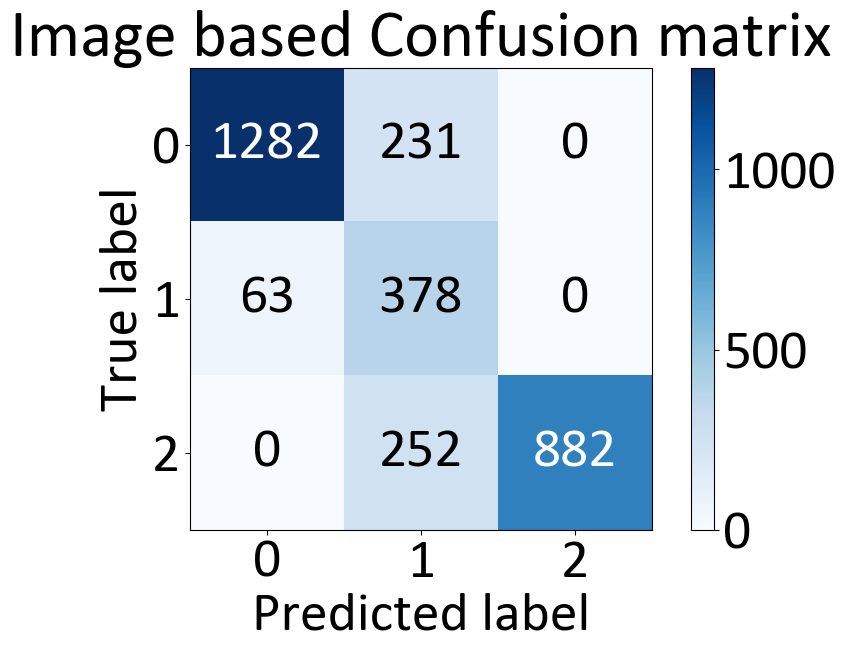

<Figure size 1000x600 with 0 Axes>

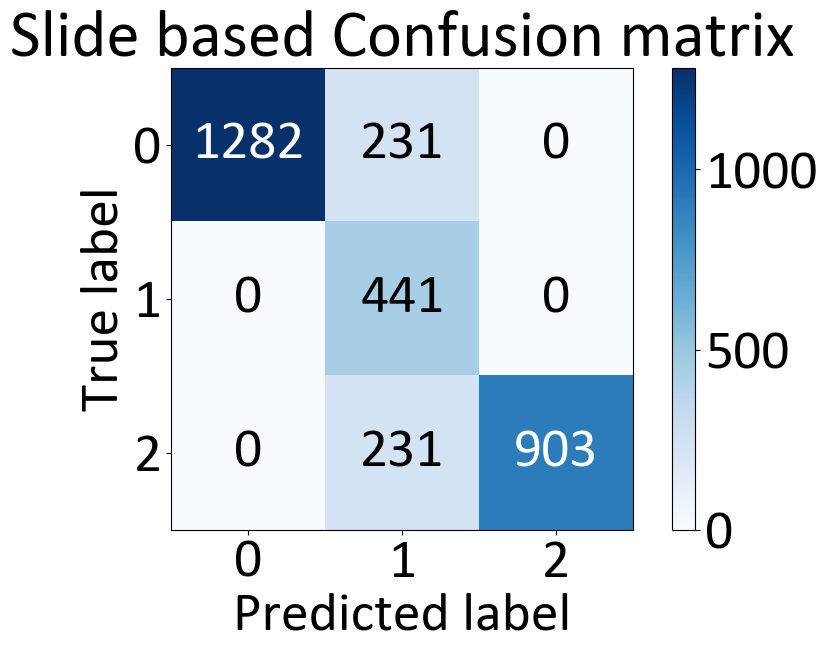

              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1513
           1       0.44      0.86      0.58       441
           2       1.00      0.78      0.88      1134

    accuracy                           0.82      3088
   macro avg       0.80      0.83      0.78      3088
weighted avg       0.90      0.82      0.84      3088

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1513
           1       0.49      1.00      0.66       441
           2       1.00      0.80      0.89      1134

    accuracy                           0.85      3088
   macro avg       0.83      0.88      0.82      3088
weighted avg       0.93      0.85      0.87      3088

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                       

<Figure size 1000x600 with 0 Axes>

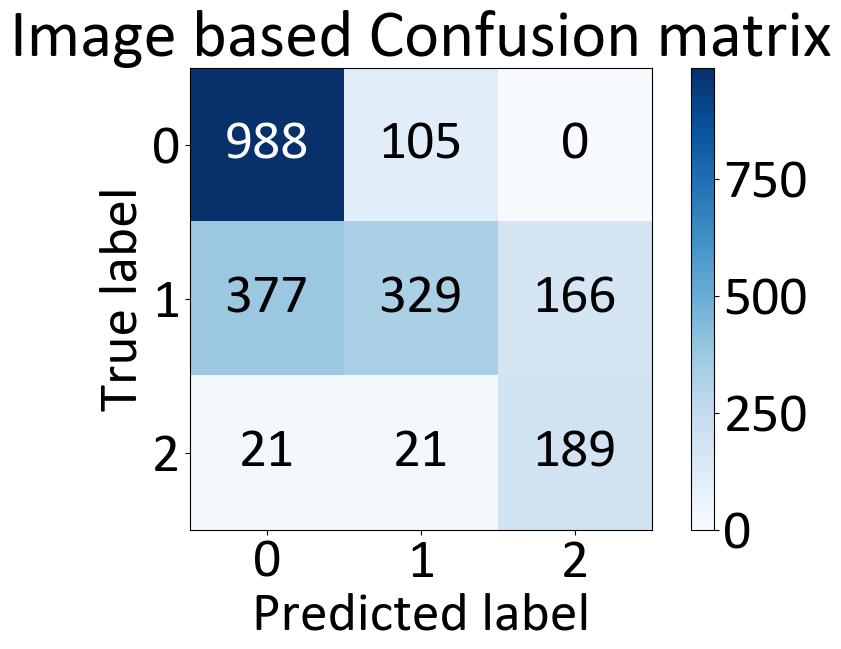

<Figure size 1000x600 with 0 Axes>

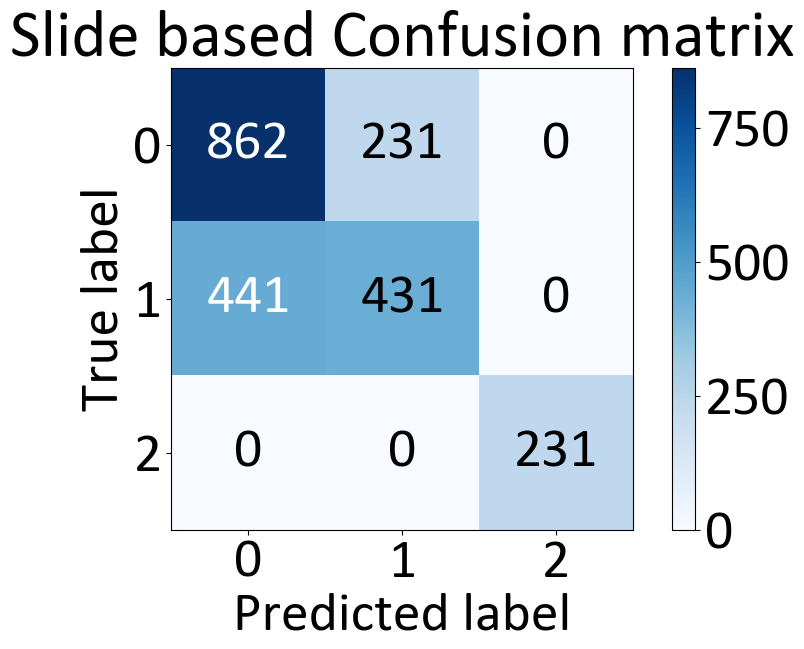

              precision    recall  f1-score   support

           0       0.71      0.90      0.80      1093
           1       0.72      0.38      0.50       872
           2       0.53      0.82      0.65       231

    accuracy                           0.69      2196
   macro avg       0.66      0.70      0.65      2196
weighted avg       0.70      0.69      0.66      2196

              precision    recall  f1-score   support

           0       0.66      0.79      0.72      1093
           1       0.65      0.49      0.56       872
           2       1.00      1.00      1.00       231

    accuracy                           0.69      2196
   macro avg       0.77      0.76      0.76      2196
weighted avg       0.69      0.69      0.69      2196

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                       

<Figure size 1000x600 with 0 Axes>

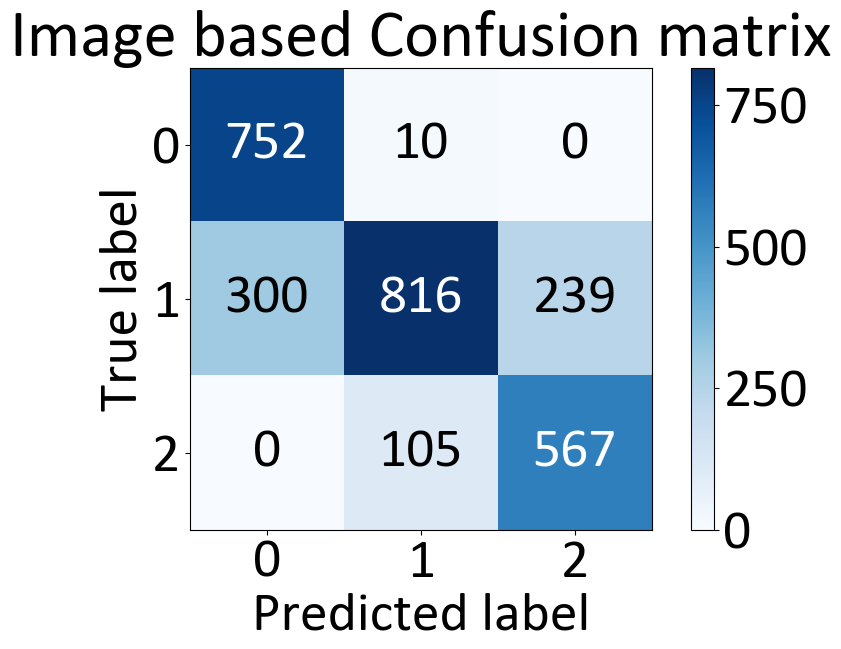

<Figure size 1000x600 with 0 Axes>

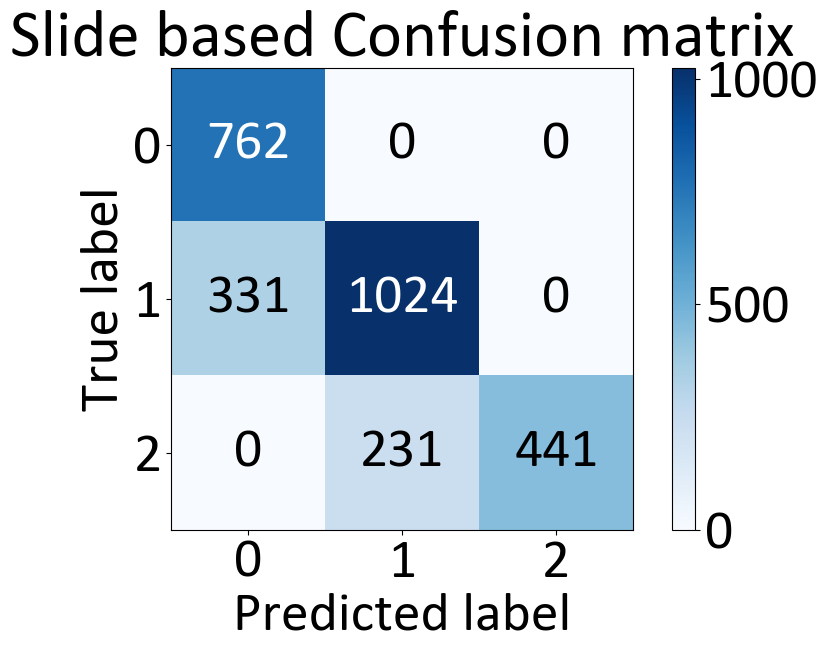

              precision    recall  f1-score   support

           0       0.71      0.99      0.83       762
           1       0.88      0.60      0.71      1355
           2       0.70      0.84      0.77       672

    accuracy                           0.77      2789
   macro avg       0.76      0.81      0.77      2789
weighted avg       0.79      0.77      0.76      2789

              precision    recall  f1-score   support

           0       0.70      1.00      0.82       762
           1       0.82      0.76      0.78      1355
           2       1.00      0.66      0.79       672

    accuracy                           0.80      2789
   macro avg       0.84      0.80      0.80      2789
weighted avg       0.83      0.80      0.80      2789



In [41]:

tile_based_scores = {}
image_based_scores = {}
slide_based_scores = {}
for val_s in validation_slide:
    #tf.keras.backend.clear_session()
    val_dir          = val_s # loop over all groups as validation dataset
    


    validation_DATA_PATH = val_dir+'_val_total_score_cropped/validation/'
    validation_LABEL_PATH = VAL_LABEL_PATH+val_dir+'_val_total_score/validation/validation_newlabels.txt'
    input_shape = (224,224,3)
    with tf.device('/CPU:0'):
        validation_images = glob.glob(validation_DATA_PATH+'*.tif')
        n_v= len(validation_images) 
        validation_samples = np.zeros((n_v, input_shape[0], input_shape[1], 3), dtype=np.float32)
        validation_label = np.zeros((n_v,), int)

        # Reading true labels of validation set
        precise_scores = []
        image_names = []
        with open(validation_LABEL_PATH,'r') as f:
            for ctr,line in zip(range(n_v),f):
                validation_samples[ctr,:,:,:] = cv2.imread(validation_DATA_PATH+(line.split()[0]))
                la = float(line.split()[1])

                if la > mid_t:
                    validation_label[ctr] = 2
                elif la > low_t:
                    validation_label[ctr] = 1
                else:
                    validation_label[ctr] = 0
                precise_scores.append(validation_label[ctr])
                image_names.append(line.split(' ')[0 ])  


        for i in range(n_v):
            mod_img = validation_samples[i,:, :].astype(np.float32)
            validation_samples[i, :, :, :] = mod_img
            
    ##After we took all validation tiles we defined the model   
    ###############################################################################################################
    pretrained_model = pretrained_model(input_shape, 2,'relu') ## REGRESSION: number of classes 1 instead of 3
    weights =glob.glob(BEST_MODEL_PATH+val_dir+'*.hdf5')
    print(weights[0])
    # Load weights, select between best_weights (val_accuracy) and final_weights from last epoch
    pretrained_model.load_weights(weights[0])

    # Make predictions on validation samples
    with tf.device('/GPU:0'):   ## by commenting this line the prediction would run on GPU 
        preds = pretrained_model.predict(validation_samples,batch_size=2)   
    
    # Max predictions in numpy array
    y_pred = np.argmax(preds,axis=1)  # 0,1 
    x_l = range(len(y_pred))

    ###################################################################################################################
    ### Here all predicted labels are saved in the following file
    with open(validation_LABEL_PATH,'r') as f: 
        with open(RESULT_PATH+model_name+'_'+val_dir+'_validation_predicted_newlabels.txt','w') as fout: 
            for i,line in zip(y_pred,f):
                print(line.split(' ')[0 ],int(i),sep=' ',file=fout)
        fout.close()
    f.close()


    #################################################Slide score #####################################################
    ##################################################################################################################
    ################################### This is for extracting slide number from images to add########################
    keys = []
    Slide_dict = {}
    with open(RESULT_PATH+model_name+'_'+val_dir+'_validation_predicted_newlabels.txt','r') as fout: 
        for line in fout:
            S_num = str(line.split(' ')[0][6:8])
            if '.' in S_num:
                S_num = S_num.replace('.','')
            if '_' in S_num:
                S_num = S_num.replace('_','')
            if S_num not in keys:
                keys.append(S_num)
                Slide_dict[S_num]=[]

    fout.close()
    ### Add all scores of tiles to the slide key
    with open(RESULT_PATH+model_name+'_'+val_dir+'_validation_predicted_newlabels.txt','r') as fout: 
        for line in fout:
            key_temp=line.split(' ')[0][6:8]
            if '.' in key_temp:
                key_temp = key_temp.replace('.','')
            if '_' in key_temp:
                key_temp = key_temp.replace('_','')
           
            Slide_dict[key_temp].append(float(line.split(' ')[1].strip()))
    #### Change all tile scores to the score of majority of tiles for slide score 
    y_pred_slide = np.ones(len(y_pred))  
    offset = 0
    ##Normalized thresholds
    

    for k in Slide_dict.keys():
        class_0 = [index for index, element in enumerate(Slide_dict[k]) if element == 0]
        class_1 = [index for index, element in enumerate(Slide_dict[k]) if element == 1]  ## First took classes
        label_3_class = len(class_1)/(len(class_0)+len(class_1))   ## Make an avareage over different tiles scores between 0 and 1.
        if label_3_class > mid_v:    ## This is where evaulation high threshold works
            majority_vote = 2
        elif label_3_class > low_v:  ## This is where evaluation low threshold works
            majority_vote = 1
        else:
            majority_vote = 0
        
        y_pred_slide[offset:offset+len(Slide_dict[k])]= majority_vote  ## all tiles belong to one slide got the same score
        offset += len(Slide_dict[k])
###################################################################################################################################
###############################################################Image score ########################################################
##################################### Add all scores of tiles to the Image name key ###############################################
    keys = []
    Image_dict = {}
    with open(RESULT_PATH+model_name+'_'+val_dir+'_validation_predicted_newlabels.txt','r') as fout: 
        for line in fout:
            I_num = str(line.split('___')[0])
            if I_num not in keys:
                keys.append(I_num)
                Image_dict[I_num]=[]

    fout.close()
    with open(RESULT_PATH+model_name+'_'+val_dir+'_validation_predicted_newlabels.txt','r') as fout: 
        for line in fout:
            key_temp=str(line.split('___')[0])
            Image_dict[key_temp].append(float(line.split(' ')[1].strip()))

    
    #### Change all tile scores to the score of majority of tiles for each image 
    y_pred_image = np.ones(len(y_pred))  
    offset = 0
    ##Normalized thresholds
    

    for k in Image_dict.keys():
        class_0 = [index for index, element in enumerate(Image_dict[k]) if element == 0]
        class_1 = [index for index, element in enumerate(Image_dict[k]) if element == 1]
        label_3_class = len(class_1)/(len(class_0)+len(class_1)) 
       
        if label_3_class > mid_v:
            majority_vote = 2
        elif label_3_class > low_v:
            majority_vote = 1
        else:
            majority_vote = 0
        
        y_pred_image[offset:offset+len(Image_dict[k])]= majority_vote
        offset += len(Image_dict[k])

    ##################################################################################################################    
    #############################Plot confusion matrix################################################################

    
    plt.figure()   ## IMAGE CM
    plot_confusion_matrix(precise_scores, y_pred_image)
    plt.title('Image based Confusion matrix')
    
    
    plt.figure()  ## SLIDE BASED CM
    plot_confusion_matrix(precise_scores, y_pred_slide)
    plt.title('Slide based Confusion matrix')
    
    plt.show()

    #########################################################Printing results ##########################################   

    print(classification_report(precise_scores,y_pred_image))
    print(classification_report(precise_scores,y_pred_slide))
    
    #tile_based_scores[val_dir]  = pd.DataFrame(classification_report(precise_scores,y_pred,output_dict=True)).transpose()
    image_based_scores[val_dir] = pd.DataFrame(classification_report(precise_scores,y_pred_image,output_dict=True)).transpose()
    slide_based_scores[val_dir] = pd.DataFrame(classification_report(precise_scores,y_pred_slide,output_dict=True)).transpose()
    ###################################################################################################################
    
#df_tile  = pd.concat([tile_based_scores['1st_part'], tile_based_scores['2nd_part'],tile_based_scores['3rd_part']], axis=1,keys=['fold1','fold2','fold3'])
df_image = pd.concat([image_based_scores['1st_part'], image_based_scores['2nd_part'],image_based_scores['3rd_part']], axis=1,keys=['fold1','fold2','fold3'])
df_slide = pd.concat([slide_based_scores['1st_part'], slide_based_scores['2nd_part'],slide_based_scores['3rd_part']], axis=1,keys=['fold1','fold2','fold3'])

#########################################################################################################################3
#df_tile.to_csv(RESULT_PATH+model_name+'_tiles.csv')
df_image.to_csv(RESULT_PATH+model_name+'_image.csv')
df_slide.to_csv(RESULT_PATH+model_name+'_slide.csv')

### Plot of full results

In [70]:
### Max and min of Median column 
max_score = max(df_scores['Median'])
min_score = min(df_scores['Median'])

##Training  ## Threshold for turning scores to damage class
low_t = (10-(min_score))/(max_score-min_score)
mid_t = (25-(min_score))/(max_score-min_score)

##Evaluation  ## Threshold for how turning tile scores to slide score
low_v = 0.25  ## 
mid_v = 0.85  ## 

### I tried different thresholds for evaludation 
### VGG16_binary  0.33 0.75
### VGG16_binary_diff_th 0.25 0.75
### VGG16_binary_diff_th_2 0.17 0.75
### VGG16_binary_diff_th_3 0.25 0.85  ## This one
### VGG16_binary_diff_th_4 0.17 0.85

validation_slide = ['3rd_part','1st_part','2nd_part'] #
model_name       = 'VGG16_binary_diff_th_3'  ## We named the model here
BEST_MODEL_PATH  = '../../../models/Extreme_classification/best/'
RESULT_PATH      = '../../../results/classification/predict_result_3cv/'

[[3137  231    0]
 [ 772 1896    0]
 [   0  462 1575]]


<Figure size 1000x600 with 0 Axes>

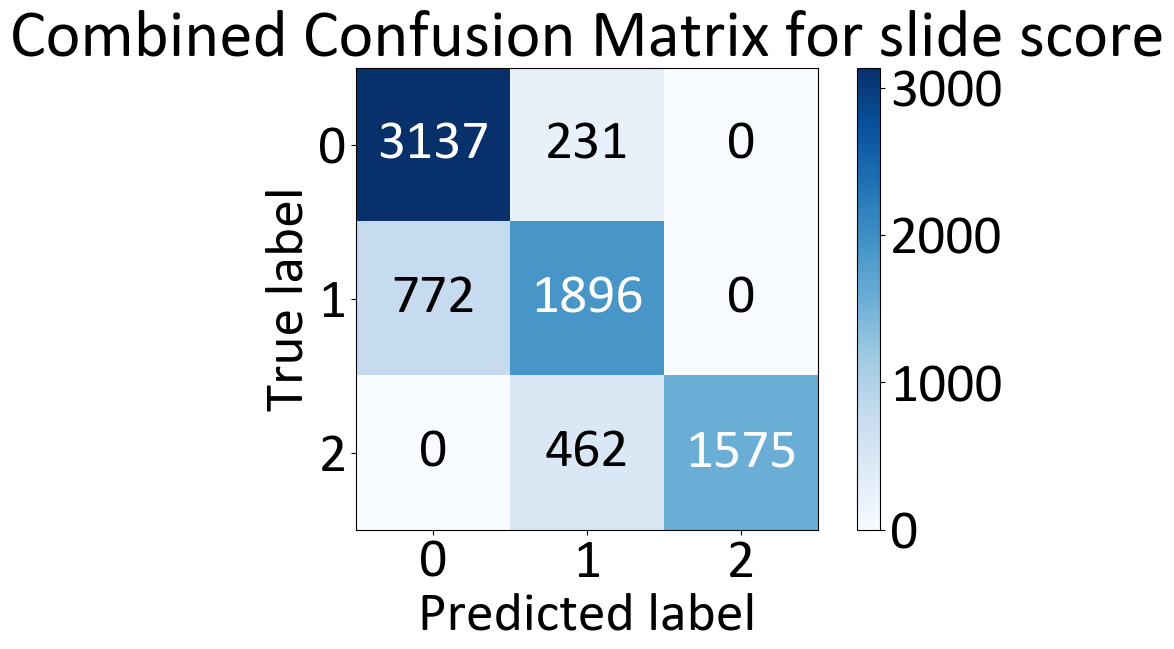

<Figure size 1000x600 with 0 Axes>

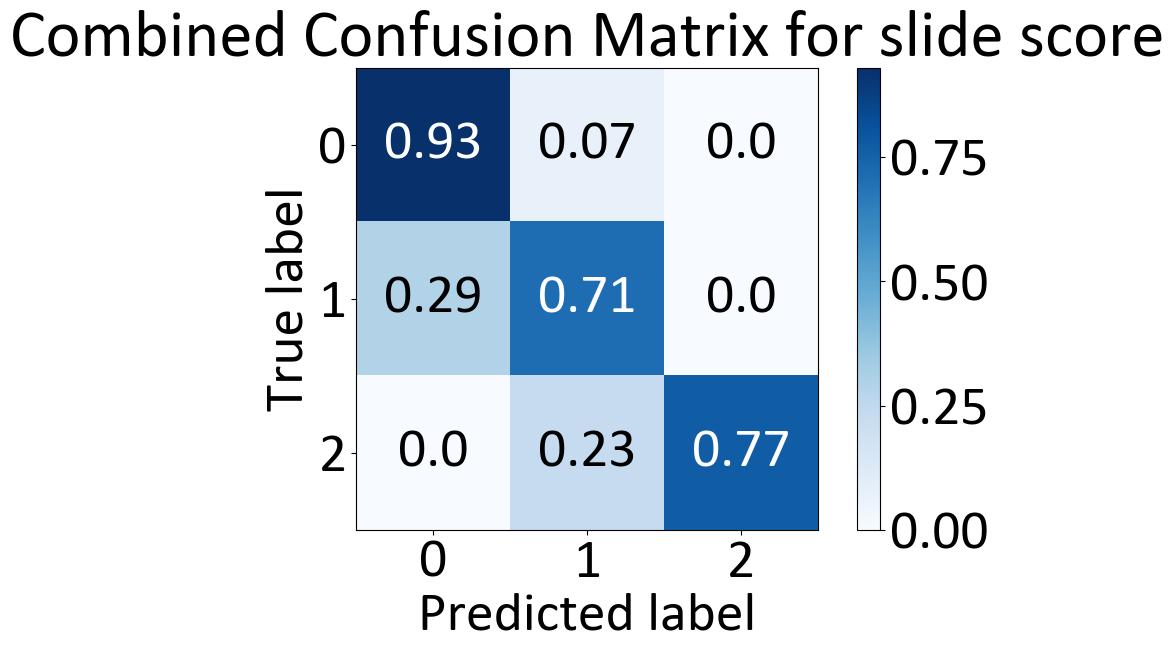

<Figure size 1000x600 with 0 Axes>

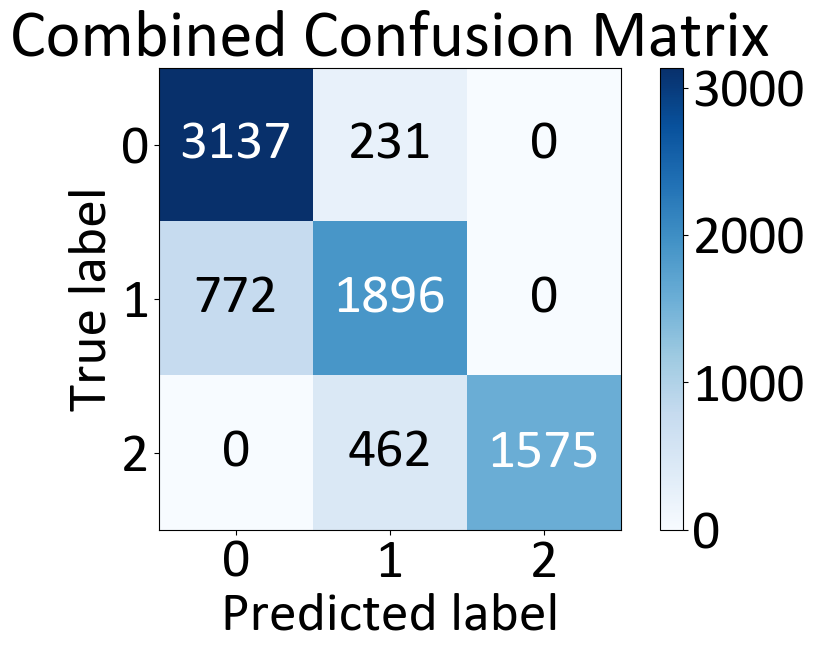

<Figure size 1000x600 with 0 Axes>

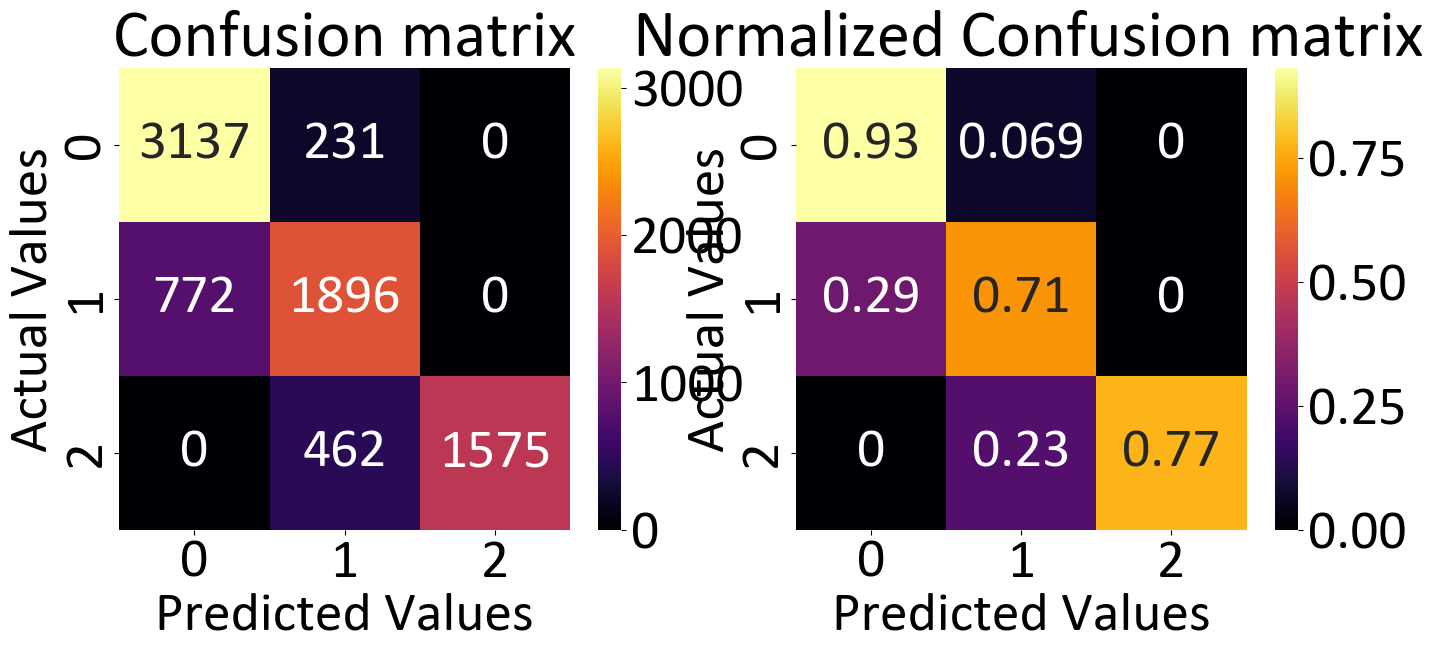

[['3137\n93.14%' '231\n6.86%' '0\n0.00%']
 ['772\n28.94%' '1896\n71.06%' '0\n0.00%']
 ['0\n0.00%' '462\n22.68%' '1575\n77.32%']]


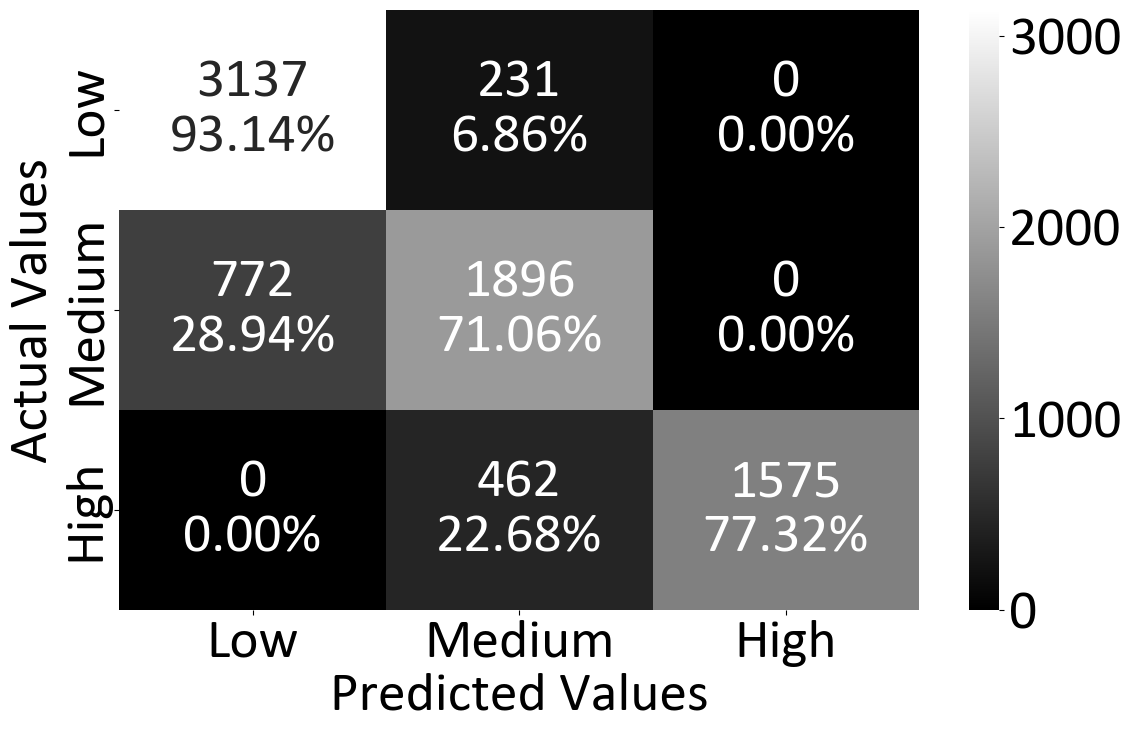

fold1                         fold2                      \
                 Precision    Recall  F1-score Precision    Recall  F1-score   
Low               0.712516  1.000000  0.832128  0.697164  1.000000  0.821563   
Medium            1.000000  0.494266  0.661550  0.815936  0.755720  0.784674   
High              1.000000  1.000000  1.000000  1.000000  0.656250  0.792453   
Micro_average     0.799180  0.799180  0.799180  0.798494  0.798494  0.798494   
weighted_average  0.856913  0.799180  0.827040  0.827835  0.798494  0.812900   

                     fold3                       Average                      
                 Precision    Recall  F1-score Precision    Recall  F1-score  
Low               1.000000  0.847323  0.917352  0.803227  0.949108  0.870095  
Medium            0.488372  1.000000  0.656250  0.768103  0.749995  0.758941  
High              1.000000  0.796296  0.886598  1.000000  0.817515  0.899597  
Micro_average     0.850389  0.850389  0.850389  0.816021  0.816021  0.816021  
weighted_average  0.926934  0.850389  0.887013  0.870561  0.816021  0.842409

In [71]:
####################################  Variables  #################################################################
G_s = []
P_s = []

tile_based_scores = {}
image_based_scores = {}
slide_based_scores = {}


#################################### Loop over all folds###########################################################
for val_dir in validation_slide:
    validation_DATA_PATH  = val_dir+'_val_total_score_cropped/validation/'
    validation_LABEL_PATH = VAL_LABEL_PATH+val_dir+'_val_total_score/validation/validation_newlabels.txt'

    
    ## Initialize validation samples
    input_shape = (224,224,3)
    validation_images = glob.glob(validation_DATA_PATH+'*.tif')
    n_v= len(validation_images) 
    validation_label = np.zeros((n_v,), int)
    
    ############################################# Gold standard scores #########################################################
    precise_scores = []
    image_names = []
    

    with open(validation_LABEL_PATH,'r') as f:
        for ctr,line in zip(range(n_v),f):
            #validation_samples[ctr,:,:,:] = cv2.imread(validation_DATA_PATH+(line.split()[0]))
            la = float(line.split()[1])
            if la > mid_t:
                validation_label[ctr] = 2
            elif la > low_t:
                validation_label[ctr] = 1
            else:
                validation_label[ctr] = 0
            precise_scores.append(validation_label[ctr])   ## gold standard scores to compare predicted ones
            image_names.append(line.split(' ')[0 ])  
    
    
    ################################################ Predicted scores ###########################################################    
    y_pred = []  
    with open(RESULT_PATH+model_name+'_'+val_dir+'_validation_predicted_newlabels.txt','r') as f:
        for line in f:
            y_pred.append(int(line.split(' ')[1].strip()))  

   ################################################ Slide number dictionary  ###################################################    
    keys = []
    Slide_dict = {}
    flag_28  = False
    with open(RESULT_PATH + model_name+'_'+val_dir+'_validation_predicted_newlabels.txt','r') as fout: 
        for line in fout:
            S_num = str(line.split(' ')[0][0:8])
            if '.' in S_num:
                S_num = S_num.replace('.','')
            if '_' in S_num:
                S_num = S_num.replace('_','')
            if S_num not in keys:
                keys.append(S_num)
                Slide_dict[S_num]=[]

    fout.close()
    ############################################ Justification for some slides ################################################
    ### Add all scores of tiles to the slide key
    with open(RESULT_PATH + model_name+'_'+val_dir+'_validation_predicted_newlabels.txt','r') as fout: 
        for line in fout:
            key_temp=line.split(' ')[0][0:8]
            if '.' in key_temp:
                key_temp = key_temp.replace('.','')
            if '_' in key_temp:
                key_temp = key_temp.replace('_','')
           
            Slide_dict[key_temp].append(float(line.split(' ')[1].strip()))

    
    ################################# Tile score to Slide score ############################################################# 
    y_pred_slide = np.ones(len(y_pred))  
    offset = 0
     
    for k in Slide_dict.keys():
        class_0 = [index for index, element in enumerate(Slide_dict[k]) if element == 0]
        class_1 = [index for index, element in enumerate(Slide_dict[k]) if element == 1]
        label_3_class = len(class_1)/(len(class_0)+len(class_1))   ## This is for turning binary classes to three class
        if label_3_class > mid_v:
            majority_vote = 2
        elif label_3_class > low_v:
            majority_vote = 1
        else:
            majority_vote = 0
       
        y_pred_slide[offset:offset+len(Slide_dict[k])]= majority_vote
        offset += len(Slide_dict[k])
    ##########################save slide scores###############################################################################
    
    tile_names = {}
    model_name_slide       = model_name+'_slide'
   
    with open(RESULT_PATH+model_name+'_'+val_dir+'_validation_predicted_newlabels.txt','r') as f:
        for line,la in zip(f,y_pred_slide):  
            name_tile = line.split(' ')[0].strip()
            if name_tile not in tile_names.keys():
                tile_names[name_tile] = la
            else:
                tile_names[name_tile] = np.append(tile_names[name_tile],la)
       
    with open(RESULT_PATH+model_name_slide+'_'+val_dir+'_validation_predicted_newlabels.txt','w') as fout:
        for k in tile_names.keys():
            print(k,int(tile_names[k]),sep =' ',file=fout)


    
    ###############################################Image name dictionary ############################################################
    ### Add all scores of tiles to the Image name key
    keys = []
    Image_dict = {}
    with open(RESULT_PATH+model_name+'_'+val_dir+'_validation_predicted_newlabels.txt','r') as fout: 
        for line in fout:
            I_num = str(line.split('___')[0])
            if I_num not in keys:
                keys.append(I_num)
                Image_dict[I_num]=[]

    fout.close()
   
    with open(RESULT_PATH+model_name+'_'+val_dir+'_validation_predicted_newlabels.txt','r') as fout: 
        for line in fout:
            key_temp=str(line.split('___')[0])
            Image_dict[key_temp].append(float(line.split(' ')[1].strip()))

   ##################################################################################################################
   #### Change all tile scores to the score of majority of tiles 
   #### Change all tile scores to the score of majority of tiles for each image 
    y_pred_image = np.ones(len(y_pred))  
    offset = 0
    for k in Image_dict.keys():
        class_0 = [index for index, element in enumerate(Image_dict[k]) if element == 0]
        class_1 = [index for index, element in enumerate(Image_dict[k]) if element == 1]
        label_3_class = len(class_1)/(len(class_0)+len(class_1)) 
        if label_3_class > mid_v:
            majority_vote = 2
        elif label_3_class > low_v:
            majority_vote = 1
        else:
            majority_vote = 0
        
        y_pred_image[offset:offset+len(Image_dict[k])]= majority_vote
        offset += len(Image_dict[k])

    ####################################################################################################################

    ############################## confusion matrix ####################################################################
    my_bins = [0, 1, 2]
    ####################################################################################################################
    ####################################################################################################################
    #################################################################################################################### 
    ##############################################Image scores table####################################################   
    image_based_scores[val_dir]  = pd.DataFrame(data=None, index=['Low','Medium','High','Micro_average','Macro_average','weighted_average'],columns=['Precision','Recall','F1-score','support'])
    ########Precision column #####################
    prec_col = np.zeros((1,6))
    image_classes = precision_score(precise_scores,y_pred_image, labels=my_bins, sample_weight=None,average=None, zero_division=0)
    image_Micro = precision_score(precise_scores,y_pred_image, sample_weight=None,average='micro', zero_division=0)
    image_Macro = precision_score(precise_scores,y_pred_image, sample_weight=None,average='macro', zero_division=0)
    image_weighted = precision_score(precise_scores,y_pred_image, sample_weight=None,average='weighted', zero_division=0)
    
    prec_col[0,0:3] = image_classes
    prec_col[0,3] = image_Micro
    prec_col[0,4] = image_Macro
    prec_col[0,5] = image_weighted
    image_based_scores[val_dir]['Precision']  = prec_col.transpose()
    #################################################################################################################
    ########Recall column ###########################################################################################
    rec_col = np.zeros((1,6))
    image_classes = recall_score(precise_scores,y_pred_image, labels=my_bins, sample_weight=None,average=None, zero_division=0)
    image_Micro = recall_score(precise_scores,y_pred_image, sample_weight=None,average='micro', zero_division=0)
    image_Macro = recall_score(precise_scores,y_pred_image, sample_weight=None,average='macro', zero_division=0)
    image_weighted = recall_score(precise_scores,y_pred_image, sample_weight=None,average='weighted')
    
    rec_col[0,0:3] = image_classes
    rec_col[0,3] = image_Micro
    rec_col[0,4] = image_Macro
    rec_col[0,5] = image_weighted
    image_based_scores[val_dir]['Recall']  = rec_col.transpose()
    ####################################################################################################################
    ##########F1-score column ###########################################################################################
    f1_score_col = np.zeros((1,6))
    image_classes = f1_score(precise_scores,y_pred_image, labels=my_bins, sample_weight=None,average=None,zero_division=0)
    image_Micro = f1_score(precise_scores,y_pred_image, sample_weight=None,average='micro',zero_division=0)
    image_Macro = f1_score(precise_scores,y_pred_image, sample_weight=None,average='macro',zero_division=0)
    image_weighted =  f1_score(precise_scores,y_pred_image, sample_weight=None,average='weighted',zero_division=0)
    
    f1_score_col[0,0:3] = image_classes
    f1_score_col[0,3] = image_Micro
    f1_score_col[0,4] = image_Macro
    f1_score_col[0,5] = image_weighted
    
    if (prec_col+rec_col).all():
        f1_score_col = (prec_col*rec_col*2) / (prec_col+rec_col)
    else :
        f1_score_col = np.ones((1,6))*0.1
    image_based_scores[val_dir]['F1-score']  =  f1_score_col.transpose()
   
    
    ##################################################Support (Number of data points)####################################   
    supprt_col = np.zeros((1,6))
    image_class0 = np.sum(np.array(precise_scores) == 0)
    image_class1 = np.sum(np.array(precise_scores) == 1)
    image_class2 = np.sum(np.array(precise_scores) == 2)
    
    image_Micro    = len(precise_scores)
    image_Macro    = len(precise_scores)
    image_weighted = len(precise_scores)
    
    supprt_col[0,0] = image_class0
    supprt_col[0,1] = image_class1
    supprt_col[0,2] = image_class2
    
    supprt_col[0,3] = image_Micro
    supprt_col[0,4] = image_Macro
    supprt_col[0,5] = image_weighted
    image_based_scores[val_dir]['support']  =  supprt_col.transpose()

    ######################################################################################################################
    ######################################################################################################################
    ######################################################################################################################
    ######################################################Slide scores ###################################################
    slide_based_scores[val_dir]  = pd.DataFrame(data=None, index=['Low','Medium','High','Micro_average','weighted_average'],
                                                columns=['Precision','Recall','F1-score'])
   ########################################################################################################################
   ##Precise column ############################################
    
    prec_col = np.zeros((1,5))
    slide_classes = precision_score(precise_scores,y_pred_slide, labels=my_bins, sample_weight=None,average=None,zero_division=0 )
    slide_Micro = precision_score(precise_scores,y_pred_slide, sample_weight=None,average='micro',zero_division=0)
    #slide_Macro = precision_score(precise_scores,y_pred_slide, sample_weight=None,average='macro', zero_division='warn')
    slide_weighted = precision_score(precise_scores,y_pred_slide, sample_weight=None,average='weighted',zero_division=0)
    
    prec_col[0,0:3] = slide_classes
    prec_col[0,3] = slide_Micro
    #prec_col[0,4] = slide_Macro
    prec_col[0,4] = slide_weighted
    slide_based_scores[val_dir]['Precision']  = prec_col.transpose()
    #######################################################################################################################
    ########recall column #######################################
    rec_col = np.zeros((1,5))
    slide_classes = recall_score(precise_scores,y_pred_slide, labels=my_bins, sample_weight=None,average=None,zero_division=0)
    slide_Micro = recall_score(precise_scores,y_pred_slide, sample_weight=None,average='micro',zero_division=0)
    #slide_Macro = recall_score(precise_scores,y_pred_slide, sample_weight=None,average='macro', zero_division='warn')
    slide_weighted = recall_score(precise_scores,y_pred_slide,average='weighted',zero_division=0)
    
    rec_col[0,0:3] = slide_classes
    rec_col[0,3] = slide_Micro
    #rec_col[0,4] = slide_Macro
    rec_col[0,4] = slide_weighted
    slide_based_scores[val_dir]['Recall']  = rec_col.transpose()
    #######################################################################################################################
    ###F1-score column ########################################
    ## Is calculated from averaged Precision and Recall. 
    f1_score_col = np.zeros((1,5))
    if (prec_col+rec_col).all():
        f1_score_col = (prec_col*rec_col*2) / (prec_col+rec_col)
    else :
        f1_score_col = np.ones((1,5))*0.1
    slide_based_scores[val_dir]['F1-score']  =  f1_score_col.transpose()
    #########################################################################################
    
    G_s = np.append(G_s, precise_scores)
    P_s = np.append(P_s, y_pred_slide)
    #############################
    #############################
 ##################################################################################################################    
 ################################## Convert to dataframe ##########################################################

df_img  = pd.concat([image_based_scores['1st_part'], image_based_scores['2nd_part'],image_based_scores['3rd_part']], axis=1,
                     keys=['fold1','fold2','fold3'])

df_slide  = pd.concat([slide_based_scores['1st_part'], slide_based_scores['2nd_part'],slide_based_scores['3rd_part']], axis=1,
                       keys=['fold1','fold2','fold3'])

###################################################################################################################
###################################################################################################################
######Merge Image based scores (weighted) #########################################################################

df_1_img = np.array(df_img.iloc[0:7,0:3]).astype(float)
df_2_img = np.array(df_img.iloc[0:7,4:7]).astype(float)
df_3_img = np.array(df_img.iloc[0:7,8:11]).astype(float)

weights_1 = np.array(df_img.iloc[0:7,3]).astype(float)*np.identity(6)
weights_2 = np.array(df_img.iloc[0:7,7]).astype(float)*np.identity(6)
weights_3 = np.array(df_img.iloc[0:7,11]).astype(float)*np.identity(6)

sum_weights = np.matmul((weights_1+weights_2+weights_3),np.ones([6,1]))
b = [np.matmul(weights_1/sum_weights,df_1_img),np.matmul(weights_2/sum_weights,df_2_img),
    np.matmul(weights_3/sum_weights,df_3_img)]

img_mean = np.sum(b,axis=0)
img_m = pd.DataFrame(img_mean,columns= ['precision','recall','f1-score'],index = ['Low','Medium','High','Micro_average','Macro_average','weighted_average'])
img_m

###################################################################################################
###Merge Slide based scores (weighted) ############################################################
df_1_slide = np.array(df_slide.iloc[0:6,0:3]).astype(float)
df_2_slide = np.array(df_slide.iloc[0:6,3:6]).astype(float)
df_3_slide = np.array(df_slide.iloc[0:6,6:9]).astype(float)


a = [df_1_slide,df_2_slide,df_3_slide]

slide_mean = np.mean(a,axis=0)
slide_m = pd.DataFrame(slide_mean,columns= ['Precision','Recall','F1-score'],
                       index = ['Low','Medium','High','Micro_average','weighted_average'])

slide_m['F1-score'] = (2*slide_m['Precision']*slide_m['Recall'])/(slide_m['Precision']+slide_m['Recall'])

#################################################################################################################
########### Plotting  Combined scores for tile and slide ########################################################

import seaborn as sns
plt.figure()
plot_confusion_matrix(G_s, P_s,labels=my_bins)
plt.title('Combined Confusion Matrix for slide score')
    
plt.figure()
plot_confusion_matrix(G_s, P_s,labels=my_bins,normalize='true')
plt.title('Combined Confusion Matrix for slide score')

plt.figure()
plot_confusion_matrix(G_s,P_s,labels=my_bins)
plt.title('Combined Confusion Matrix')

plt.figure()
print(confusion_matrix(G_s,P_s))

#########################################Settings ##################################################################
cm_normalized = confusion_matrix(G_s,P_s).astype('float') / confusion_matrix(G_s,P_s).sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
rc = {'figure.figsize':(10,6),
      'axes.facecolor':'white',
      'axes.grid' : False,
      'grid.color': '.6',
      'font.family':'Calibri',
      'font.size' :40}
plt.rcParams.update(rc)

sns.heatmap(confusion_matrix(G_s,P_s),fmt="", annot=True, ax = ax1,cmap='inferno')
ax1.set_title('Confusion matrix')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')

sns.heatmap(cm_normalized, annot=True, ax = ax2,cmap='inferno')
ax2.set_title(' Normalized Confusion matrix')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
plt.show()

####################################################################################################################
GPS= confusion_matrix(G_s,P_s)
NGPS = cm_normalized


labels = (np.asarray(["{0}\n{1:0.2f}%".format(t, 100*s) for t, s in zip(GPS.flatten(),NGPS.flatten())])).reshape(3, 3)
print(labels)

fig_2 = plt.figure(figsize = (10,6))
ax = fig_2.add_axes([1,0,1,1])
sns.heatmap(GPS, annot=labels, fmt="", ax=ax,yticklabels=['Low','Medium','High'],xticklabels=['Low','Medium','High'],cmap='gray')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
plt.show()

rc = {'figure.figsize':(10,6),
      'axes.facecolor':'white',
      'axes.grid' : True,
      'font.family':'Nato',
      'font.size' :40}
plt.show()
##########################################################################################################
#### Combined dataframes for all folds

df_vgg_binary_slide  = pd.concat([slide_based_scores['1st_part'], slide_based_scores['2nd_part'],slide_based_scores['3rd_part'],slide_m], axis=1,keys=['fold1','fold2','fold3','Average'])
#df_effnet_man_aug_slide

df_vgg_binary_slide

